In [1]:
#Import modules
import collections
import datetime
import time
import requests

import pandas as pd
import sqlite3 as lite
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

In [2]:
#Hard code cities :(
city_loc=collections.defaultdict()
city_loc={'Denver':'39.761850,-104.881105','Cleveland':'41.478462,-81.679435',
         'Minneapolis':'44.963324,-93.268320','Washington':'38.904103,-77.017229',
         'Seattle':'47.620499,-122.350876'}

In [3]:
#===
#Build MaxTemp Database
#===
#Create SQLite commands
sql=""
for key in city_loc.keys():
    sql = sql + str(key) + " INT, "

#Key of API & url
APIkey='7d19355e20465a946c9207815d652a28'
URLbase='https://api.forecast.io/forecast/'

#Create database
con = lite.connect('weather.db')
cur = con.cursor()

with con:
    cur.execute('DROP TABLE IF EXISTS MaxTemp')
    cur.execute("CREATE TABLE MaxTemp (date INT, "+sql[:-2]+")")
    
    for i in range(30,0,-1):
        evaldate=datetime.datetime.now()-datetime.timedelta(days=i)
        cur.execute('INSERT INTO MaxTemp (date) VALUES (?)', 
                    (evaldate.strftime("%Y-%m-%d"),))
        
        for key,val in city_loc.items():
            r = requests.get(URLbase + APIkey + '/' + val + ','
                             + str(int(time.mktime(evaldate.timetuple()))))
            
            cur.execute('UPDATE MaxTemp SET ' + str(key) + ' = ' + 
                        str(r.json()['daily']['data'][0]['apparentTemperatureMax']) + 
                        ' WHERE date = ' + "'" + evaldate.strftime("%Y-%m-%d") + "';")

Temperature Date Range: 2016-06-28 to 2016-07-27

Max Temperature Details for Seattle:
Max Max Temperature: 81.02
Max Temperature Range: 16.89
Mean Max Temperature: 71.15
Max Temperature Variance: 20.32

Max Temperature Details for Washington:
Max Max Temperature: 111.08
Max Temperature Range: 38.42
Mean Max Temperature: 92.64
Max Temperature Variance: 84.51

Max Temperature Details for Minneapolis:
Max Max Temperature: 105.12
Max Temperature Range: 34.90
Mean Max Temperature: 84.61
Max Temperature Variance: 71.50

Max Temperature Details for Denver:
Max Max Temperature: 92.16
Max Temperature Range: 17.00
Mean Max Temperature: 84.98
Max Temperature Variance: 15.83

Max Temperature Details for Cleveland:
Max Max Temperature: 97.34
Max Temperature Range: 25.30
Mean Max Temperature: 84.09
Max Temperature Variance: 56.45



([<matplotlib.axis.XTick at 0xdf32b38>,
 <a list of 30 Text xticklabel objects>)

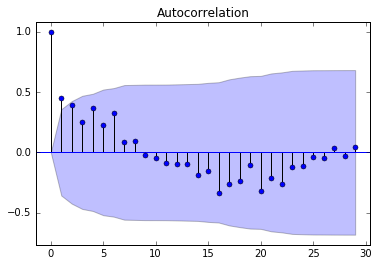

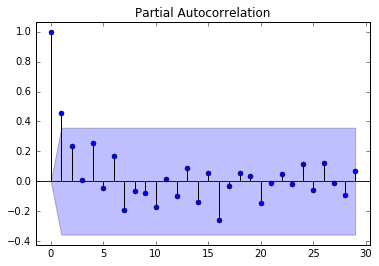

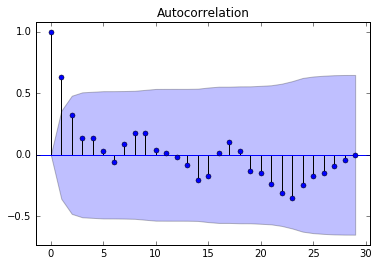

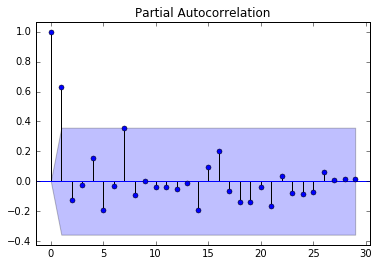

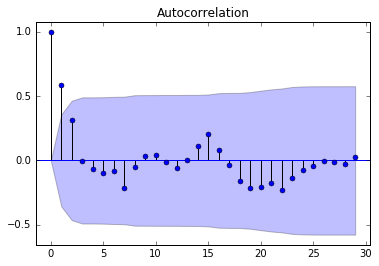

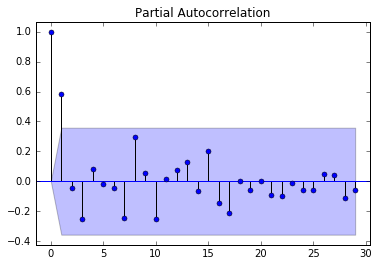

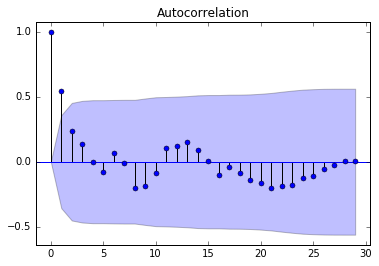

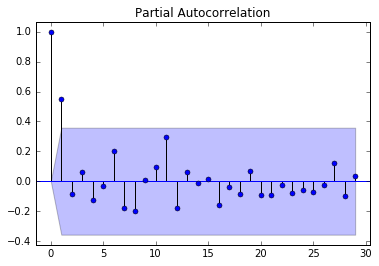

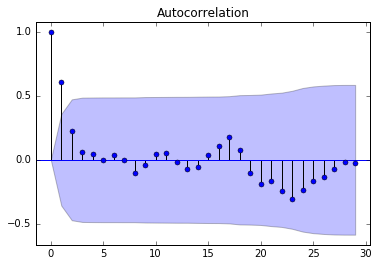

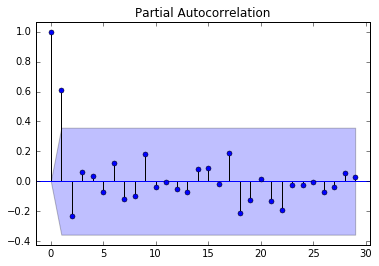

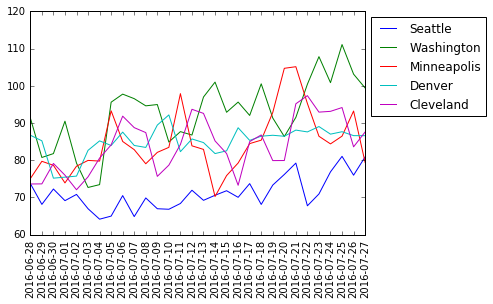

In [4]:
#Query database and place into pandas
MTemp=pd.read_sql_query('SELECT * FROM MaxTemp ORDER BY date',con,index_col='date')

print('Temperature Date Range: %s to %s\n' % (min(MTemp.index),max(MTemp.index)))

for key in MTemp.keys():
    print('Max Temperature Details for %s:' % key)
    print('Max Max Temperature: %0.2f' % max(MTemp[key]))
    print('Max Temperature Range: %0.2f' % (max(MTemp[key])-min(MTemp[key])))
    print('Mean Max Temperature: %0.2f' % MTemp[key].mean())
    print('Max Temperature Variance: %0.2f\n' % MTemp[key].var())
    
    sm.graphics.tsa.plot_acf(MTemp[key].values)
    sm.graphics.tsa.plot_pacf(MTemp[key].values)

plt.figure()
for key in MTemp.keys():
    plt.plot([datetime.datetime.strptime(d,"%Y-%m-%d") for d in MTemp.index],[t for t in MTemp[key]])

plt.legend([key for key in MTemp.keys()],loc='upper left',bbox_to_anchor=(1,1))
plt.xticks([datetime.datetime.strptime(d,"%Y-%m-%d") 
            for d in MTemp.index],[d for d in MTemp.index], rotation='vertical')

In [5]:
#Minneapolis had the largest change in max temperature over the time period.

#There is a slight oscillation in the autocorrelation graphs for
#max temperature data.  A larger dataset is needed to better understand 
#the oscillation frequency and any linear trends.


Washington has the largest max temperature delta with a 22.16 degree change



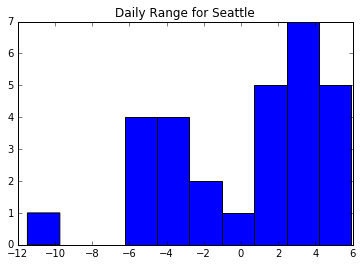

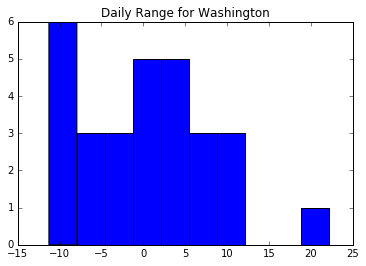

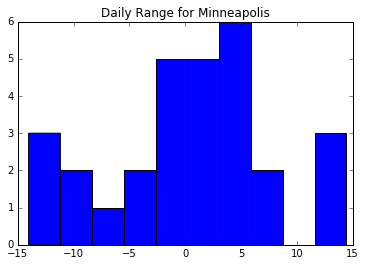

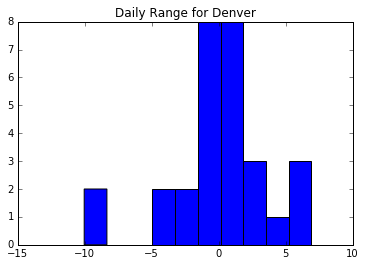

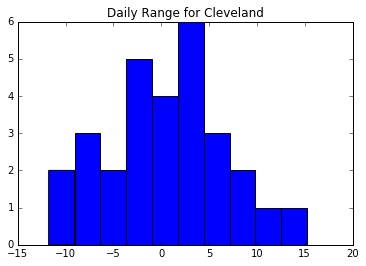

In [6]:
TempRange=pd.DataFrame(index=[datetime.datetime.strptime(MTemp.index[i],"%Y-%m-%d") 
                              - datetime.datetime.strptime(MTemp.index[0],"%Y-%m-%d") 
                              for i in range(1,len(MTemp.index))],columns=MTemp.columns)

for key, val in MTemp.iteritems():
    TempRange[key]=[val[i] - val[i-1] for i in range(1,len(val))]

print('%s has the largest max temperature delta with a %0.2f degree change\n' 
      % (max(abs(TempRange)),max(abs(TempRange[max(abs(TempRange))]))))

for key in TempRange.keys():
    plt.figure()
    plt.hist(TempRange[key])
    plt.title('Daily Range for %s' % key)